In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import string
import time
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import glob

In [2]:
imgres = 128

def get_simple_model():
    model = Sequential()
    model.add(layers.Conv2D(8, (5, 5), activation='relu', strides=1,
                            input_shape=(imgres, imgres, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu', strides=1))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def get_better_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgres, imgres, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [3]:
model = get_simple_model()
model.load_weights("models/catdog_simple")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13457     
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
____________________________________________________

In [4]:
def preprocess_resize(x):
    x = resize(x, (imgres, imgres), anti_aliasing=True)
    return np.array(x, dtype=np.float32)/255

datagen = ImageDataGenerator(preprocessing_function = preprocess_resize)
img_load = datagen.flow_from_directory("myexamples",
        class_mode="binary", batch_size=64, shuffle=True,
        target_size=(imgres, imgres))
Xs = img_load.next()
predictions = model(Xs).numpy().flatten()
print(predictions)

Found 4 images belonging to 3 classes.
[0.98375344 0.0385752  0.95114076 0.02471245]


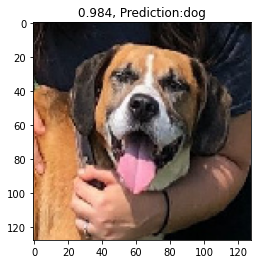

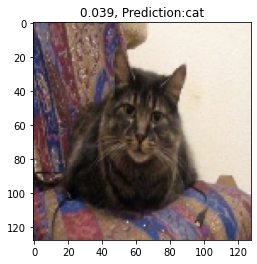

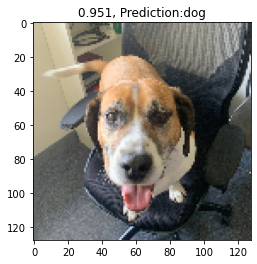

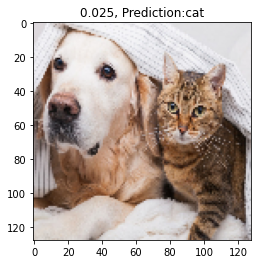

In [5]:
for k in range(Xs[0].shape[0]):
    plt.figure()
    x = Xs[0][k, :, :, :]
    plt.imshow(x)
    pred = predictions[k]
    s = "{:.3f}, Prediction:{}".format(pred, ["cat", "dog"][int(pred > 0.5)])
    plt.title(s);

In [6]:
def plot_layers(x):
    weights, bias = model.layers[0].weights
    weights = weights.numpy()
    y = model.layers[0](x[None, :, :, :])
    plt.figure(figsize=(y.shape[-1]*3, 6))
    vmin = np.min(y)
    vmax = np.max(y)
    for k in range(y.shape[-1]):
        plt.subplot(2, y.shape[-1], k+1)
        plt.imshow(np.array(255*weights[:, :, :, k], dtype=np.uint8))
        plt.subplot(2, y.shape[-1], y.shape[-1]+k+1)
        plt.imshow(y[0, :, :, k], cmap='magma', vmin=vmin, vmax=vmax)



    y2 = model.layers[1](y)
    y2 = model.layers[2](y2)
    weights, bias = model.layers[2].weights
    weights = weights.numpy()
    print(weights.shape)
    print(y2.shape)
    vmin = np.min(y2)
    vmax = np.max(y2)
    M = weights.shape[-2]
    N = weights.shape[-1]
    res = 3
    plt.figure(figsize=(res*N, res*M))
    for m in range(M):
        for n in range(N):
            plt.subplot(M+1, N, N*m + n+1)
            plt.imshow(weights[:, :, m, n])
            plt.axis("off")
    for n in range(N):
        plt.subplot(M+1, N, M*N + n + 1)
        plt.imshow(y2[0, :, :, n], cmap='magma')

(5, 5, 8, 16)
(1, 58, 58, 16)


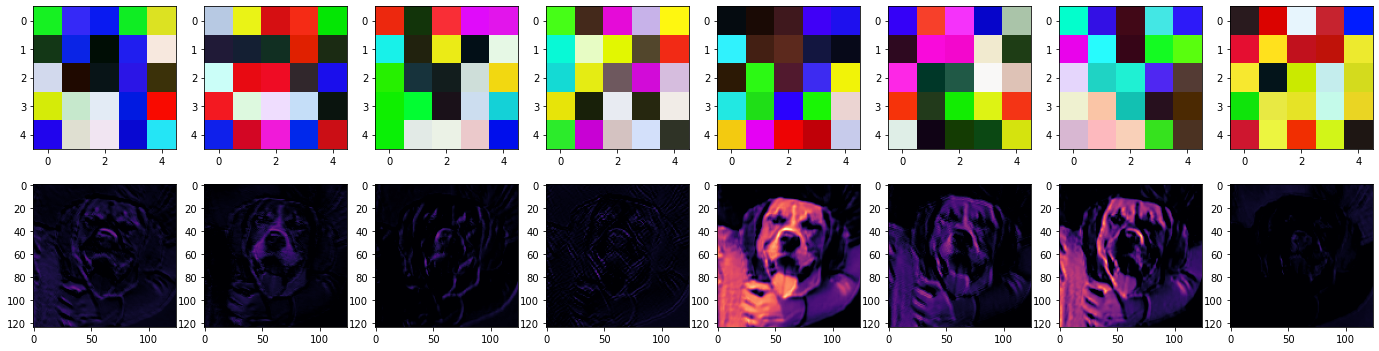

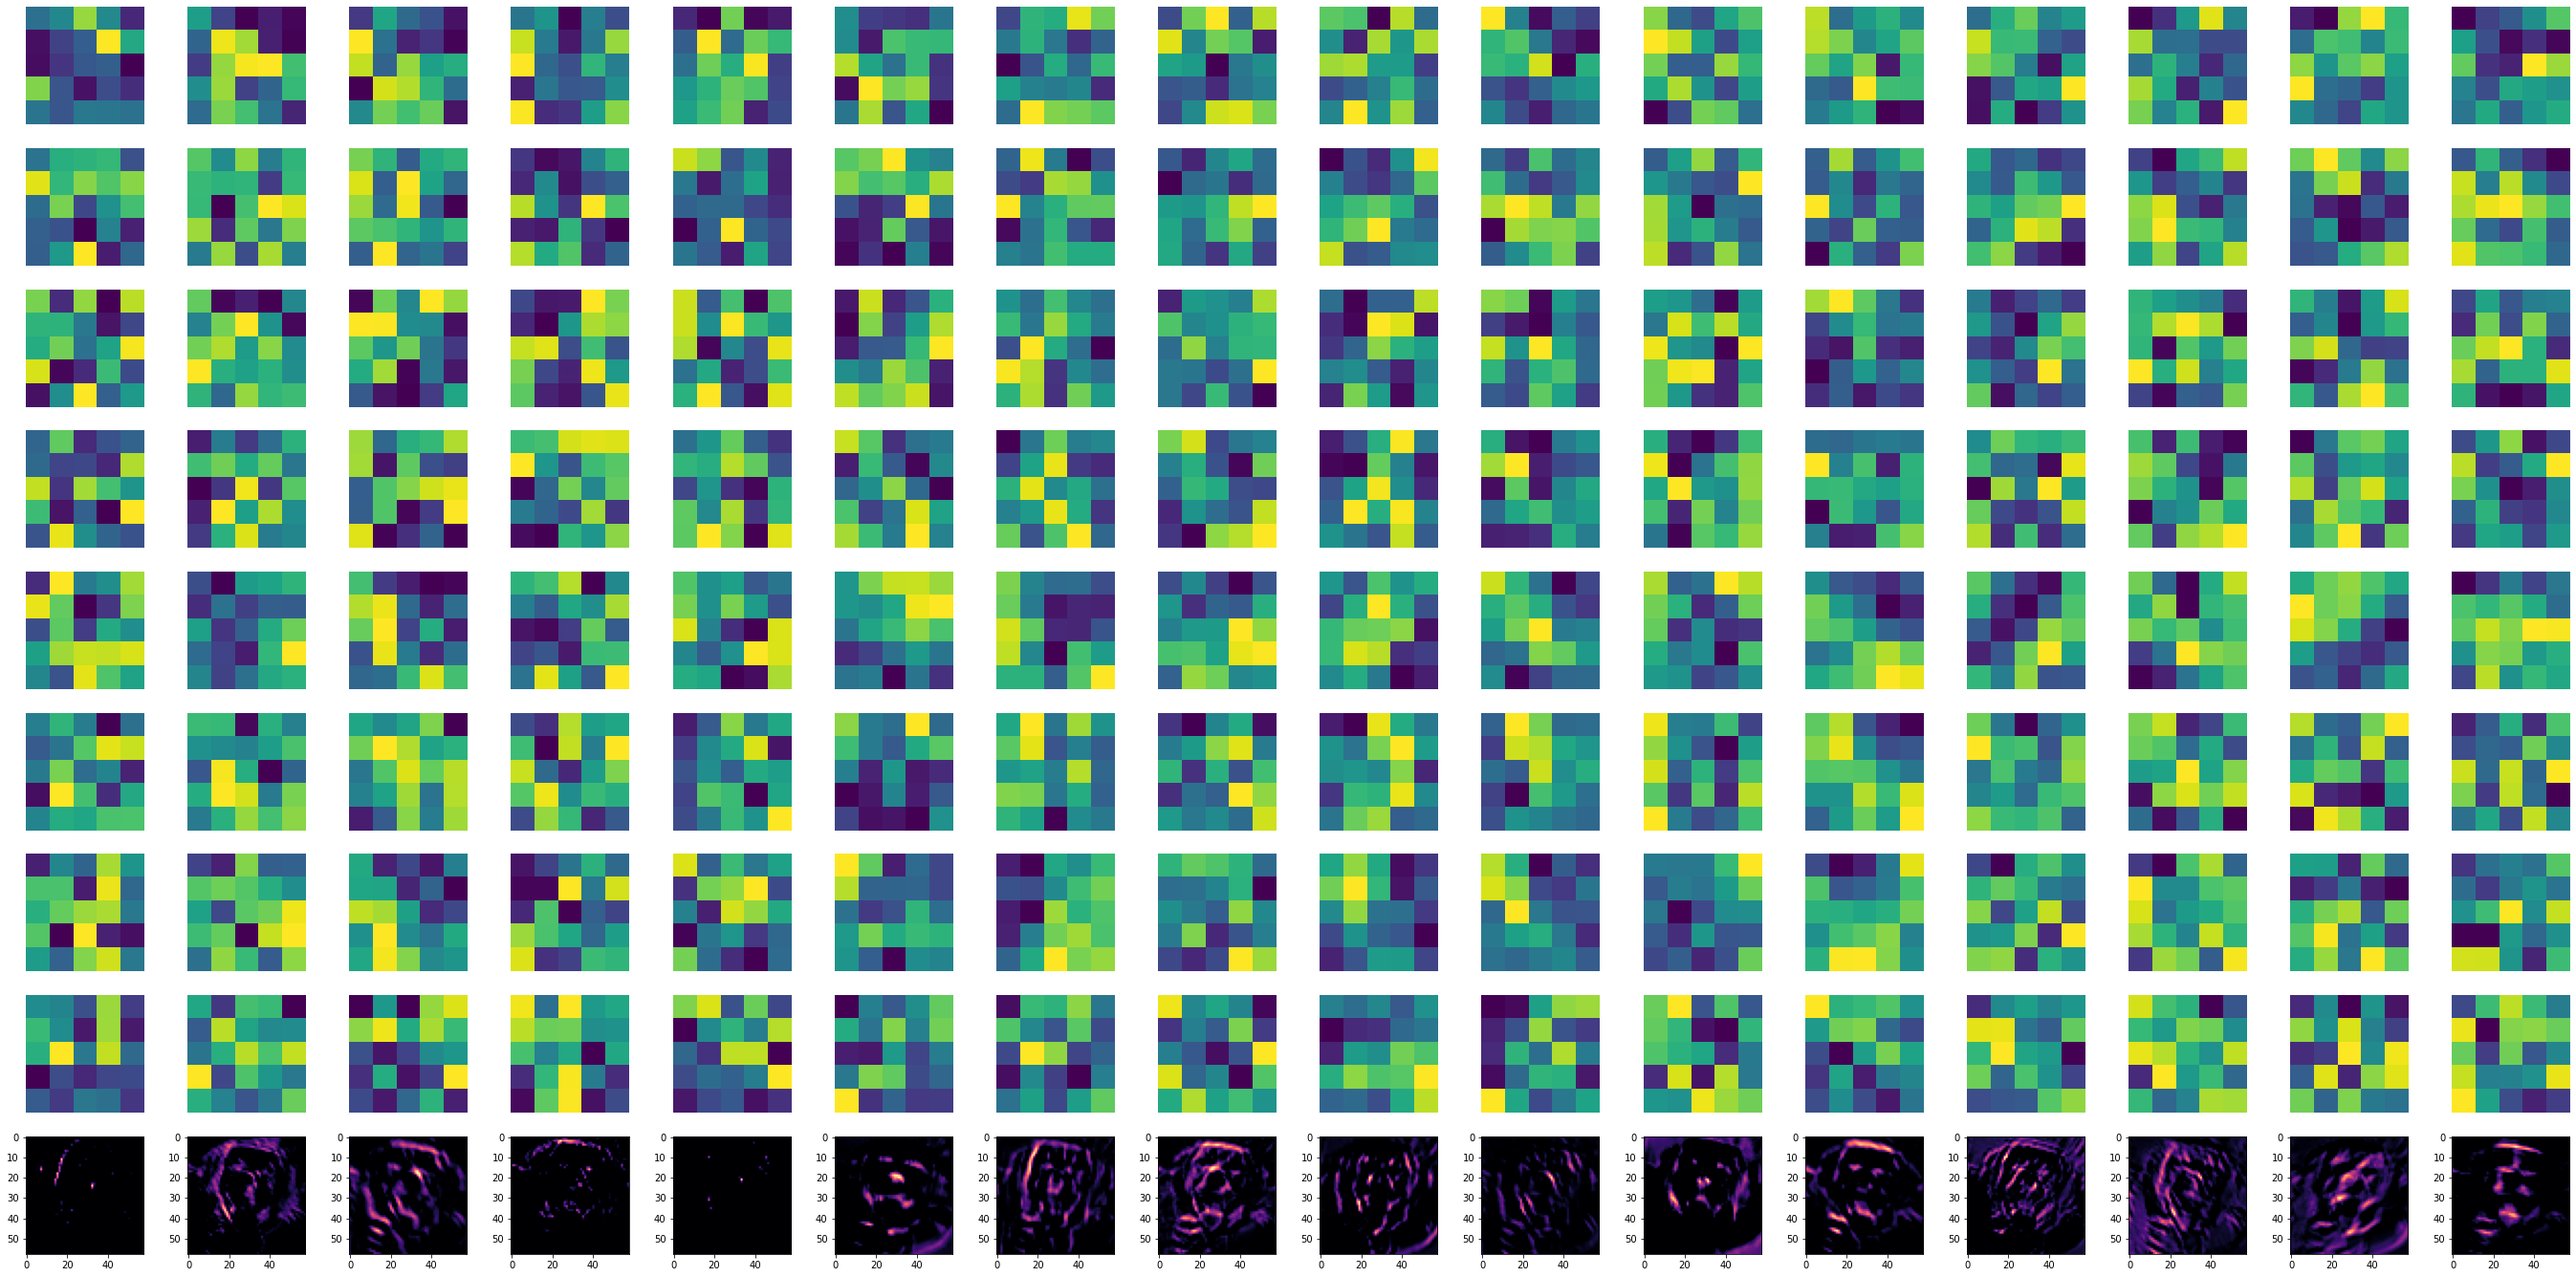

In [7]:
plot_layers(Xs[0][0, :, :, :])